# 3 - Pre-trained models

## Group 1

Mikołaj Jarząbkowski | 20230529 <br>
Rodrigo Silva | 20230536 <br>
Nicolau Dulea | 20230544 <br>
Joana Gonçalves | 20230977 <br>
Tiago Fernandes | 20230988 <br>

## Imports

In [72]:
from numpy.random import seed
seed(42)
import pandas as pd
import numpy as np
import os, shutil
import io
import seaborn as sns
import requests
import urllib
import bs4
import re
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# keras
#! pip install tensorflow 
from tensorflow.random import set_seed
tensorflow.random.set_seed(42)
# importing needed libraries
#%tensorflow_version 1.x
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, concatenate, RandomRotation, RandomZoom,Rescaling, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, models, callbacks, layers
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.applications import VGG16, ResNet50, MobileNet, InceptionV3, DenseNet121, EfficientNetB0
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras import backend as K

import warnings
warnings.filterwarnings("ignore")

# Defining needed functions

#### Function to import images

In [63]:
def import_images(with_data_augmentation, batch_size, image_size=(224, 224)):
    """
    Parameters:
        batch_size (int): Batch size to be used.
        image_size (tuple): Size of the images (width, height) - By default is (256, 256).
        
    Returns:
        train_generator : Training dataset generator.
        val_generator : Validation dataset generator.
        image_size (tuple): Size of the images.
    """
    if with_data_augmentation.lower() != "yes":
        train_generator = tf.keras.utils.image_dataset_from_directory("X_train_final",batch_size = batch_size, image_size= image_size, label_mode = "int",seed=42)
    else:
        train_generator = tf.keras.utils.image_dataset_from_directory("X_train_final_aug",batch_size = batch_size, image_size= image_size, label_mode = "int",seed=42)
    
    train_generator = train_generator.map(lambda x,y: (x/255, y))
    
    val_generator = tf.keras.utils.image_dataset_from_directory("X_val",batch_size = batch_size, image_size= image_size, label_mode = "int",seed=42)
    val_generator = val_generator.map(lambda x,y: (x/255, y))
    
    return train_generator, val_generator, image_size

#### Function to train the model

In [67]:
def train_model(model, epochs):
    """
    Trains the model for the specified number of epochs.

    Parameters:
        model : The neural network model to train.
        train_generator : The training dataset generator.
        val_generator : The validation dataset generator.
        epochs (int): The number of epochs to train the model for.

    Returns:
         History containing training metrics.
    """
    train_generator,val_generator, _ = import_results
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
    cp = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True)
    hist = model.fit(train_generator, epochs=epochs, callbacks=[es, cp], validation_data=val_generator)
    return hist

#### Function to predictions

In [76]:
def predictions(model, batch_size, image_size):
    test_generator = tf.keras.utils.image_dataset_from_directory("X_test", batch_size= batch_size,
                                                                 image_size=image_size, label_mode="int",
                                                                 seed=42, shuffle=False)
    label_names = test_generator.class_names
    test_generator = test_generator.map(lambda x, y: (x/255, y))

 
    true_labels = []
    predicted_labels = []

    
    for batch in test_generator.as_numpy_iterator():
        X, y = batch
        Y_pred = model.predict(X)
        y_pred = np.argmax(Y_pred, axis=1)

    
        true_labels.extend(y)
        predicted_labels.extend(y_pred)

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    f1 = f1_score(true_labels, predicted_labels, average='micro')
    print("F1 Score:",f1)

#### Function to get the loss graphs

In [7]:
def history_model(history):
    """
    Plots the training and validation loss and accuracy from the provided history object.

    Parameters:
        history (tf.keras.callbacks.History): History object containing training metrics.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1,len(loss)+1)
    plt.plot(epochs,loss, "y", label = "Training Loss")
    plt.plot(epochs,val_loss, "r", label = "Validation Loss")
    plt.title("Training and Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    f1 = history.history["f1_score"]
    val_f1 = history.history["val_f1_score"]
    epochs = range(1,len(loss)+1)
    plt.plot(epochs,f1, "y", label = "Training f1 score")
    plt.plot(epochs,val_f1, "r", label = "Validation f1 score")
    plt.title("Training and Validation f1 score")
    plt.xlabel("Epochs")
    plt.ylabel("F1 score")
    plt.legend()
    plt.show()
    

# Models

## VGG16

Found 50881 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                      

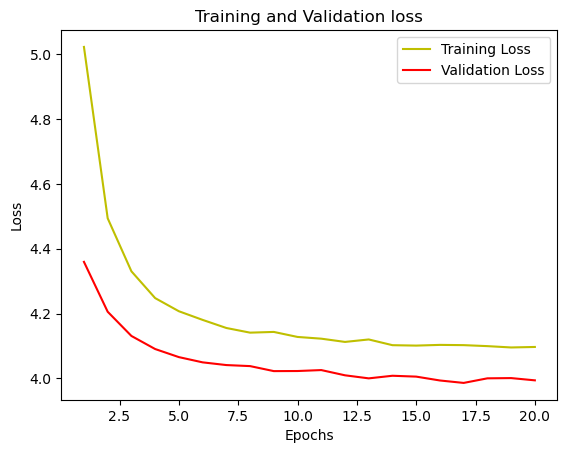

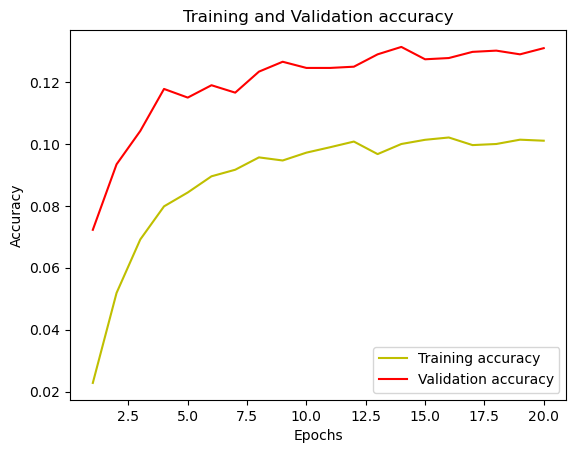

In [18]:
import_results = import_images("yes", 128, (224, 224))

def model_vgg16():
    # Load pre-trained VGG16 model
    vgg16 = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False, pooling='max')
    for layer in vgg16.layers:
        layer.trainable = False
    
    x = Flatten()(vgg16.output)
    x = Dropout(0.6)(x)
    prediction = Dense(114, activation='softmax')(x)
    
    model = Model(inputs=vgg16.input, outputs=prediction)
    model.summary()
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


model_vgg16 = model_vgg16()
hist_vgg16 = train_model(model_vgg16, 30)
predictions(model_vgg16, 64, (224, 224))
history_model(hist_vgg16)

In [28]:
test_generator = tf.keras.utils.image_dataset_from_directory("X_test", batch_size=64, image_size=(224, 244), label_mode="int", seed=42, shuffle=False)

model_vgg16.evaluate(test_generator)

Found 2457 files belonging to 114 classes.
39/39 [==============================] - 579s 15s/step - loss: 157.1986 - accuracy: 0.0537


[157.1986083984375, 0.053724054247140884]

In [86]:
val_generator = tf.keras.utils.image_dataset_from_directory("X_val", batch_size = 128, image_size=(224, 244), label_mode = "int", seed=42)

Found 2505 files belonging to 114 classes.


In [88]:
model_vgg16.evaluate(val_generator)

20/20 [==============================] - 833s 41s/step - loss: 154.5893 - accuracy: 0.0515


[154.58932495117188, 0.05149700492620468]

## InceptionV3

In [9]:
import_results = import_images("yes", 128, (299, 299))

def model_inceptionv3():
    # Load pre-trained InceptionV3 model
    inceptionv3 = InceptionV3(input_shape=(299, 299, 3), weights='imagenet', include_top=False, pooling='max')
    for layer in inceptionv3.layers:
        layer.trainable = False
    
    x = Flatten()(inceptionv3.output)
    x = Dropout(0.6)(x)
    prediction = Dense(114, activation='softmax')(x)
    
    model = Model(inputs=inceptionv3.input, outputs=prediction)
    model.summary()
    model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


model_inceptionv3 = model_inceptionv3()
hist_inceptionv3 = train_model(model_inceptionv3, 20)
predictions(model_inceptionv3, 64, (299, 299))
history_model(hist_inceptionv3)

Found 50881 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 149, 149, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 149, 149, 32)         96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 acti

KeyboardInterrupt: 

## EfficientNetB0

Found 50881 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_5[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 resc

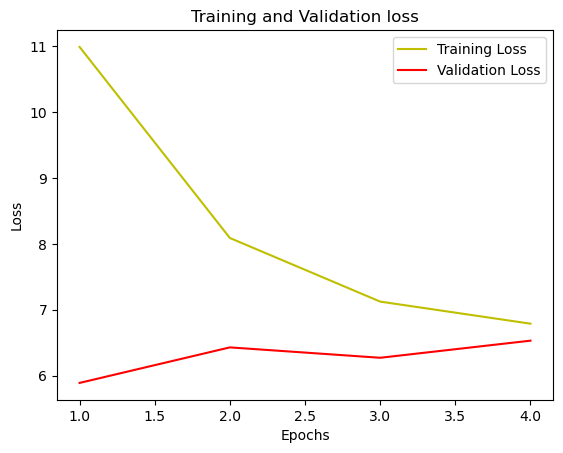

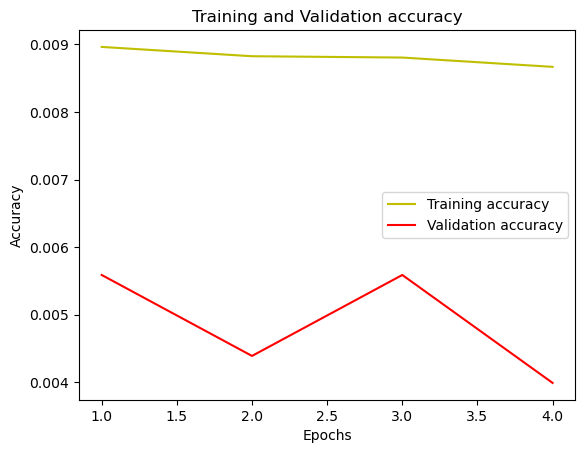

In [16]:
import_results = import_images("yes", 128, (224, 224))

def model_efficientnetb0():
    # Load pre-trained EfficientNetB0 model
    efficientnetb0 = EfficientNetB0(input_shape=(224, 224, 3), weights='imagenet', include_top=False, pooling='max')
    for layer in efficientnetb0.layers:
        layer.trainable = False
    
    x = Flatten()(efficientnetb0.output)
    x = Dropout(0.6)(x)
    prediction = Dense(114, activation='softmax')(x)
    
    model = Model(inputs=efficientnetb0.input, outputs=prediction)
    model.summary()
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


model_efficientnetb0 = model_efficientnetb0()
hist_efficientnetb0 = train_model(model_efficientnetb0, 20)
model_efficientnetb0.evaluate(test_generator)
predictions(model_efficientnetb0, 64, (224, 224))
history_model(hist_efficientnetb0)

In [29]:
model_efficientnetb0.evaluate(test_generator)

39/39 [==============================] - 89s 2s/step - loss: 7.2443 - accuracy: 0.0077


[7.24434232711792, 0.0077330078929662704]

In [89]:
model_efficientnetb0.evaluate(val_generator)

20/20 [==============================] - 99s 4s/step - loss: 7.3021 - accuracy: 0.0064


[7.302116870880127, 0.006387225352227688]

Found 50881 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_29 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 224, 224, 3)          0         ['input_29[0][0]']            
                                                                                                  
 normalization_2 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 res

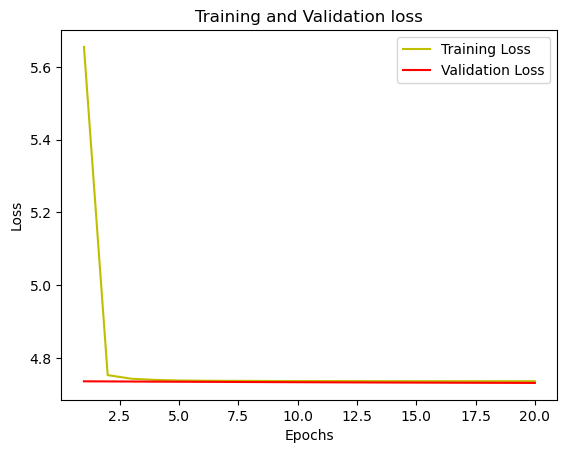

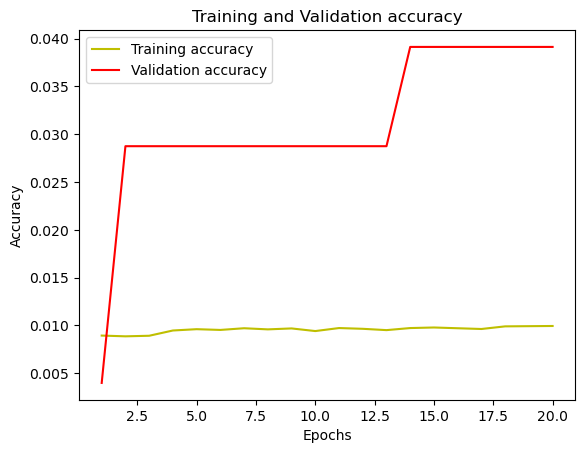

39/39 [==============================] - 78s 2s/step - loss: 4.7318 - accuracy: 0.0379


[4.731838226318359, 0.037851039320230484]

In [83]:
import_results = import_images("yes", 128, (224, 224))

def model_efficientnetb0_1():
    # Load pre-trained EfficientNetB0 model
    efficientnetb0_1 = EfficientNetB0(input_shape=(224, 224, 3), weights='imagenet', include_top=False, pooling='max')
    for layer in efficientnetb0_1.layers:
        layer.trainable = False
    
    x = Flatten()(efficientnetb0_1.output)
    x = Dropout(0.6)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    prediction = Dense(114, activation='softmax')(x)
    
    model = Model(inputs=efficientnetb0_1.input, outputs=prediction)
    model.summary()
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


model_efficientnetb0_1 = model_efficientnetb0_1()
hist_efficientnetb0_1 = train_model(model_efficientnetb0_1, 20)
predictions(model_efficientnetb0_1, 64, (224, 224))
history_model(hist_efficientnetb0_1)
model_efficientnetb0_1.evaluate(test_generator)

In [90]:
model_efficientnetb0_1.evaluate(val_generator)

20/20 [==============================] - 80s 4s/step - loss: 4.7324 - accuracy: 0.0387


[4.732421875, 0.038722556084394455]

## ResNet50

Found 50881 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
94765736/94765736 [==============================] - 21s 0us/step
Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_26 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_26[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 1

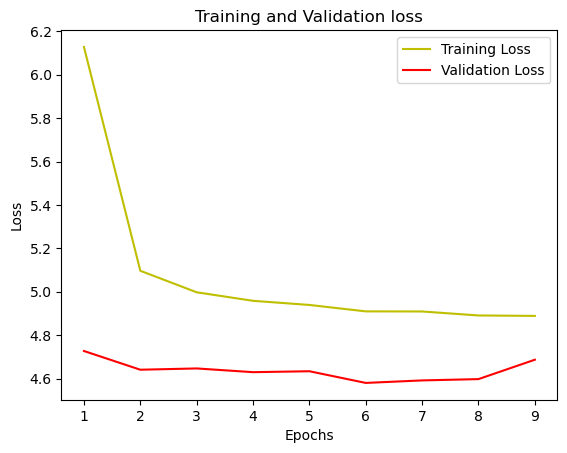

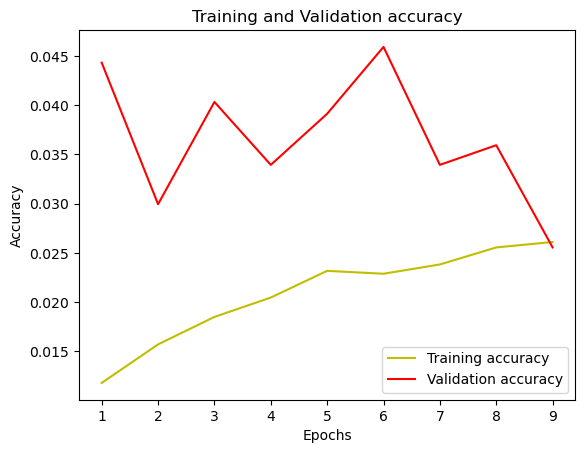

In [78]:
import_results = import_images("yes", 128, (224, 224))

def model_resnet50():
    # Load pre-trained ResNet50 model
    resnet50 = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False, pooling='max')
    for layer in resnet50.layers:
        layer.trainable = False
    
    x = Flatten()(resnet50.output)
    x = Dropout(0.6)(x)
    prediction = Dense(114, activation='softmax')(x)
    
    model = Model(inputs=resnet50.input, outputs=prediction)
    model.summary()
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

model_resnet50 = model_resnet50()
hist_resnet50 = train_model(model_resnet50, 20)
model_resnet50.evaluate(test_generator)
predictions(model_resnet50, 64, (224, 224))
history_model(hist_resnet50)

In [79]:
model_resnet50.evaluate(test_generator)

39/39 [==============================] - 189s 5s/step - loss: 165.4557 - accuracy: 0.0065


[165.45571899414062, 0.0065120067447423935]

In [91]:
model_resnet50.evaluate(val_generator)

20/20 [==============================] - 214s 11s/step - loss: 167.1739 - accuracy: 0.0072


[167.1739044189453, 0.007185628637671471]

## MobileNet

Found 50881 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                      

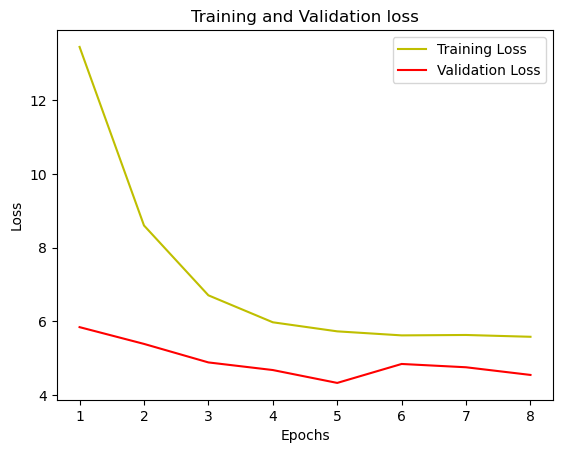

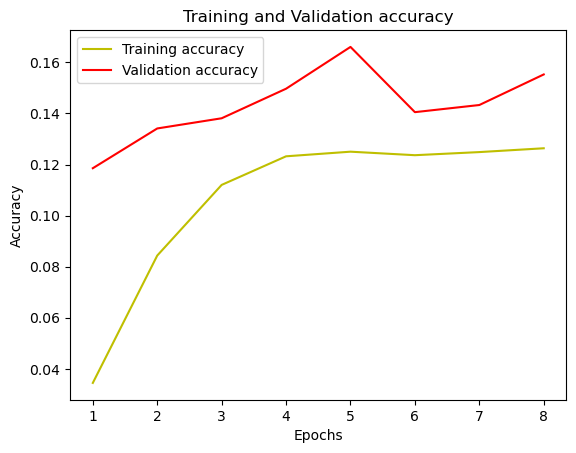

In [14]:
import_results = import_images("yes", 128, (224, 224))

def model_mobilenet():
    # Load pre-trained MobileNet model
    mobilenet = MobileNet(input_shape=(224, 224, 3), weights='imagenet', include_top=False, pooling='max')
    for layer in mobilenet.layers:
        layer.trainable = False
    
    x = Flatten()(mobilenet.output)
    x = Dropout(0.6)(x)
    prediction = Dense(114, activation='softmax')(x)
    
    model = Model(inputs=mobilenet.input, outputs=prediction)
    model.summary()
    model.compile(optimizer=RMSprop(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


model_mobilenet = model_mobilenet()
hist_mobilenet = train_model(model_mobilenet, 20)
predictions(model_mobilenet, 64, (224, 224))
history_model(hist_mobilenet)

In [30]:
model_mobilenet.evaluate(test_generator)

39/39 [==============================] - 53s 1s/step - loss: 7.3621 - accuracy: 0.0065


[7.362115859985352, 0.0065120067447423935]

Found 50881 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                     

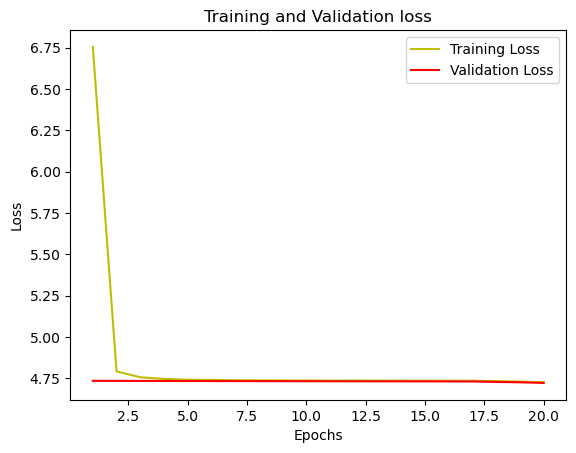

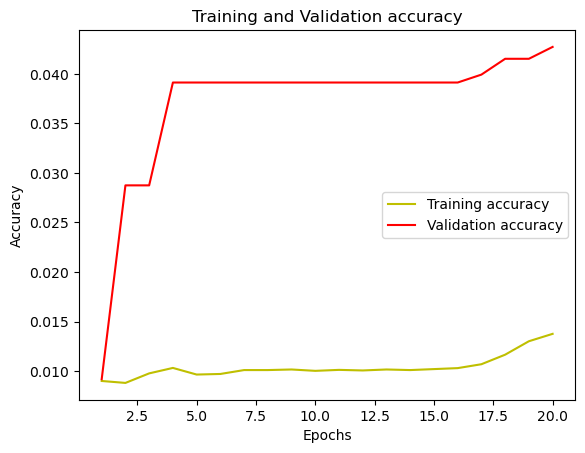

39/39 [==============================] - 47s 1s/step - loss: 4.7273 - accuracy: 0.0370


[4.727279186248779, 0.03703703731298447]

In [82]:
import_results = import_images("yes", 128, (224, 224))

def model_mobilenet():
    # Load pre-trained MobileNet model
    mobilenet1 = MobileNet(input_shape=(224, 224, 3), weights='imagenet', include_top=False, pooling='max')
    for layer in mobilenet1.layers:
        layer.trainable = False
    
    x = Flatten()(mobilenet1.output)
    x = Dropout(0.6)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    prediction = Dense(114, activation='softmax')(x)
    
    model = Model(inputs=mobilenet1.input, outputs=prediction)
    model.summary()
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


model_mobilenet1 = model_mobilenet()
hist_mobilenet1 = train_model(model_mobilenet1, 20)
predictions(model_mobilenet1, 64, (224, 224))
history_model(hist_mobilenet1)
model_mobilenet1.evaluate(test_generator)

In [93]:
model_mobilenet1.evaluate(val_generator)

20/20 [==============================] - 53s 2s/step - loss: 4.7263 - accuracy: 0.0383


[4.726309776306152, 0.038323353976011276]

## DenseNet121

Found 50881 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
29084464/29084464 [==============================] - 7s 0us/step
Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_30 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_30[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                      

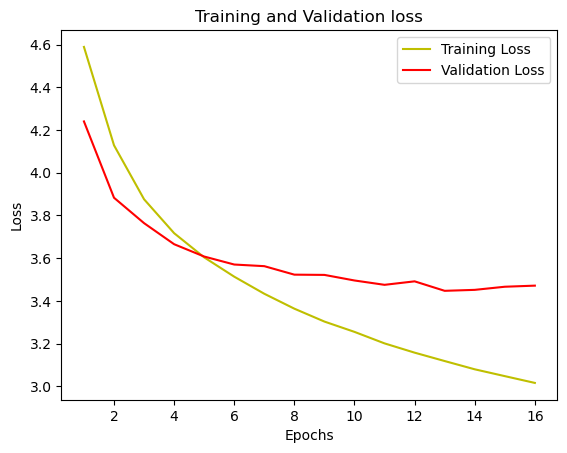

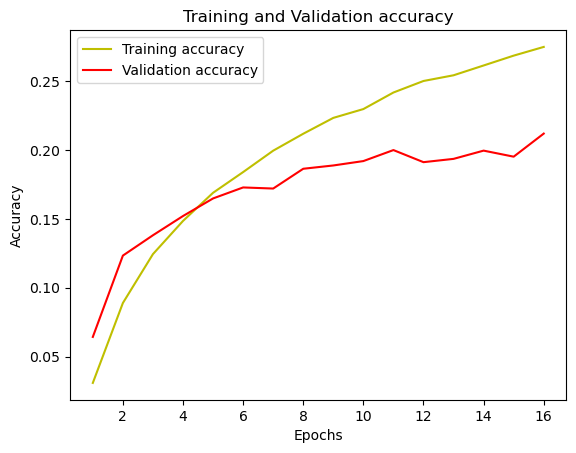

In [94]:
import_results = import_images("yes", 128, (224, 224))
def model_densenet121():
    # Load pre-trained DenseNet121 model
    densenet121 = DenseNet121(input_shape=(224, 224, 3), weights='imagenet', include_top=False, pooling='max')
    for layer in densenet121.layers:
        layer.trainable = False
    
    x = Flatten()(densenet121.output)
    x = Dense(228, activation = "relu")(x)
    x = Dense(228, activation = "relu")(x)
    x = Dense(200, activation = "relu")(x)
    x = Dropout(0.6)(x)
    prediction = Dense(114, activation='softmax')(x)
    
    model = Model(inputs=densenet121.input, outputs=prediction)
    model.summary()
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


model_densenet121 = model_densenet121()
hist_densenet121 = train_model(model_densenet121, 35)
predictions(model_densenet121, 64, (224, 224))
history_model(hist_densenet121)

In [95]:
model_densenet121.evaluate(val_generator)

20/20 [==============================] - 156s 7s/step - loss: 21.1201 - accuracy: 0.0104


[21.120086669921875, 0.010379241779446602]

In [96]:
model_densenet121.evaluate(test_generator)

39/39 [==============================] - 136s 3s/step - loss: 21.2222 - accuracy: 0.0098


[21.22224998474121, 0.00976801011711359]